# Analyzing Time-series Data with FTGPs

We use time-series decomposition to try to explain/analyze the quality of our FTGPs. Time-series decomposition helps us break down a time-series dataset into three main components:

**1. Trend:** The trend component represents the long-term movement in the data, representing the underlying pattern.

**2. Seasonality:** The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.

**3. Residual (Noise):** The residual component represents random variability that remains after removing the trend and seasonality.

By separating these components, we can gain insights into the behavior of the data and make better forecasts. 

## Types of Time Series Decomposition Techniques

### a) Additive Decomposition

* In additive decomposition, the time series is expressed as the sum of its components. It’s suitable when the magnitude of seasonality doesn’t vary with the magnitude of the time series.

$$Y(t) = Trend(t) + Seasonal(t) + Residual(t)$$

### b) Multiplicative Decomposition

* In multiplicative decomposition, the time series is expressed as the product of its components.It’s suitable when the magnitude of seasonality scales with the magnitude of the time series.

$$Y(t) = Trend(t) * Seasonal(t) * Residual(t)$$

## Methods of Decomposition
### a) Moving Averages

* Moving averages involve calculating the average of a certain number of past data points. It helps smooth out fluctuations and highlight trends.

### b) Seasonal Decomposition of Time Series

* The Seasonal and Trend decomposition using Loess (STL) is a popular method for decomposition, which uses a combination of local regression (Loess) to extract the trend and seasonality components.

### c) Exponential Smoothing State Space Model

* This method involves using the ETS framework to estimate the trend and seasonal components in a time series.

## Reference
* https://www.geeksforgeeks.org/time-series-decomposition-techniques/


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import from local directory
import sys

sys.path.insert(0, '../src')
from TemporalGP.TGP.tgrad_ami import TGradAMI
from TemporalGP.TGP.t_graank import TGrad

In [2]:
# Hyperparameters

# f_path = "../datasets/air_quality1k.csv"
eq = False
min_sup = 0.5
tgt_col = 2
min_rep = 0.5
num_cores = 4

f_path = "aqy1k_transformed_data.csv"

In [3]:
data = pd.read_csv(f_path)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1292,112,9.4,955,103,1174,92,1559,972,18.5,65.2,1.0411
1,3/10/2004,19:00:00,2.0,1402,88,9.0,939,131,1140,114,1555,1074,21.0,58.9,1.0746
2,3/10/2004,20:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,21.3,59.5,0.9974
3,3/10/2004,21:00:00,2.2,1272,51,6.5,836,131,1205,116,1490,1110,21.3,57.7,0.8997
4,3/10/2004,22:00:00,1.6,1197,38,4.7,750,89,1337,96,1393,949,21.3,56.1,0.9087


In [4]:
tgp = TGradAMI(f_path, eq, min_sup, tgt_col, min_rep, num_cores)
# tgp.full_attr_data

Dataset Ok


In [5]:
data_gp = TGradAMI.process_time(tgp.data)
new_data = data_gp.data
data_df = pd.DataFrame(data=new_data[1:, :], columns=new_data[0, :])
data_df

,2808997200.0,2,1402,88,9.0,939,131,1140,114,1555,1074,21.0,58.9,1.0746
0,2809000800.0,2.2,1376,80,9.2,948,172,1092,122,1584,1203,21.3,59.5,0.9974
1,2809004400.0,2.2,1272,51,6.5,836,131,1205,116,1490,1110,21.3,57.7,0.8997
2,2809008000.0,1.6,1197,38,4.7,750,89,1337,96,1393,949,21.3,56.1,0.9087
3,2809011600.0,1.2,1185,31,3.6,690,62,1462,77,1333,733,21.3,58.0,0.8881
4,2809015200.0,1.2,1136,31,3.3,672,62,1453,76,1333,730,20.2,58.4,0.8581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2810775600.0,2.2,1197,117,6.5,837,144,957,118,1498,965,14.6,66.1,0.9038
494,2810779200.0,1.7,1277,156,7.7,886,140,902,109,1579,1004,14.4,68.9,0.8880
495,2810782800.0,1.9,1430,332,11.3,1025,204,779,123,1772,1166,13.9,45.0,0.8841
496,2810786400.0,2.9,1242,232,9.1,944,149,846,114,1638,991,13.5,30.7,0.9085


In [36]:
datetime_series = pd.to_datetime(new_data[1:, 0].astype(float), unit='s')
datetime_index = pd.DatetimeIndex(datetime_series, freq='h')
#datetime_index

In [7]:
ts_1 = pd.Series(new_data[1:, 1], index=datetime_index)  # CO(GT)
ts_2 = pd.Series(new_data[1:, 5], index=datetime_index)  # NMHC(GT)
ts_3 = pd.Series(new_data[1:, 7], index=datetime_index)  # PT08.S3(NOx)
ts_4 = pd.Series(new_data[1:, 8], index=datetime_index)  # NO2(GT)

ts_n = pd.Series(new_data[1:, 11], index=datetime_index)  # T

DTW distance: 468294.19999999995
DTW distance: 515850.19999999995
DTW distance: 49638.600000000064
DTW distance: 9262.599999999999


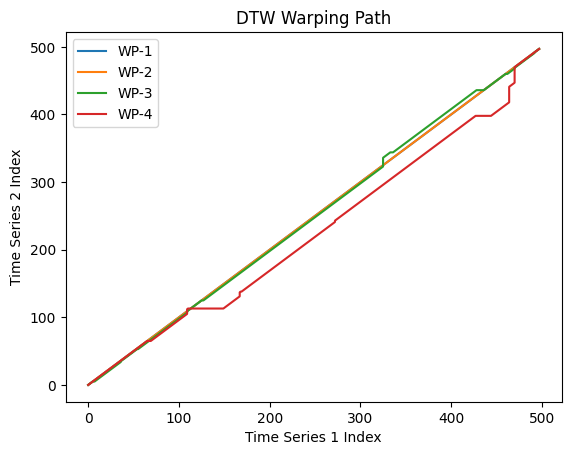

In [9]:
distance1, path1 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 5].reshape(-1, 1), dist=euclidean)
distance2, path2 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 7].reshape(-1, 1), dist=euclidean)
distance3, path3 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 8].reshape(-1, 1), dist=euclidean)
distance4, path4 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 11].reshape(-1, 1), dist=euclidean)

print(f"DTW distance: {distance1}")
print(f"DTW distance: {distance2}")
print(f"DTW distance: {distance3}")
print(f"DTW distance: {distance4}")

plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="WP-1")
plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="WP-2")
plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="WP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], '-', label="WP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()


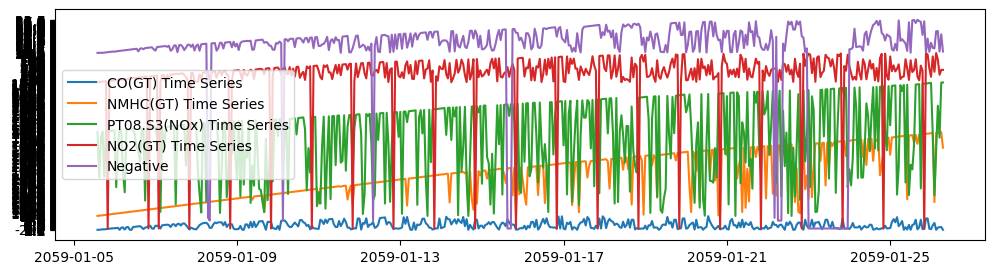

In [37]:

plt.figure(figsize=(12, 3))
plt.plot(ts_1, label='CO(GT) Time Series')
plt.plot(ts_2, label='NMHC(GT) Time Series')
plt.plot(ts_3, label='PT08.S3(NOx) Time Series')
plt.plot(ts_4, label='NO2(GT) Time Series')
plt.plot(ts_n, label='Negative')
plt.legend()

In [11]:
# Decompose time-series
result_add1 = seasonal_decompose(ts_1, model='additive')
result_add2 = seasonal_decompose(ts_2, model='additive')
result_add3 = seasonal_decompose(ts_3, model='additive')
result_add4 = seasonal_decompose(ts_4, model='additive')

result_addn = seasonal_decompose(ts_n, model='additive')


In [27]:
# Get Long trends
result_trend1 = np.array(result_add1.trend)
result_trend2 = np.array(result_add2.trend)
result_trend3 = np.array(result_add3.trend)
result_trend4 = np.array(result_add4.trend)
result_trend5 = np.array(result_addn.trend)

result_season1  = np.array(result_add1.seasonal)
result_season2 = np.array(result_add2.seasonal)
result_season3 = np.array(result_add3.seasonal)
result_season4 = np.array(result_add4.seasonal)
result_season5 = np.array(result_addn.seasonal)

result_trend1 = result_trend1[~np.isnan(result_trend1)]
result_trend2 = result_trend2[~np.isnan(result_trend2)]
result_trend3 = result_trend3[~np.isnan(result_trend3)]
result_trend4 = result_trend4[~np.isnan(result_trend4)]
result_trend5 = result_trend5[~np.isnan(result_trend5)]

result_season1 = result_season1[~np.isnan(result_season1)]
result_season2 = result_season2[~np.isnan(result_season2)]
result_season3 = result_season3[~np.isnan(result_season3)]
result_season4 = result_season4[~np.isnan(result_season4)]
result_season5 = result_season5[~np.isnan(result_season5)]


# Normalization
scaler = MinMaxScaler()

result_norm1 = scaler.fit_transform(result_trend1.reshape(-1, 1))
result_norm2 = scaler.fit_transform(result_trend2.reshape(-1, 1))
result_norm3 = scaler.fit_transform(result_trend3.reshape(-1, 1))
result_norm4 = scaler.fit_transform(result_trend4.reshape(-1, 1))
result_norm5 = scaler.fit_transform(result_trend5.reshape(-1, 1))


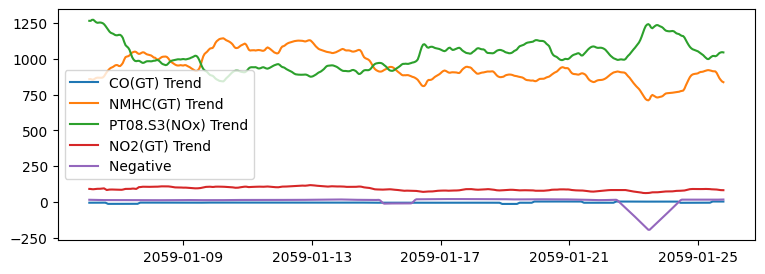

In [25]:
# Plotting 'Trend' Component

plt.figure(figsize=(9, 3))
plt.plot(result_add1.trend, label='CO(GT) Trend')
plt.plot(result_add2.trend, label='NMHC(GT) Trend')
plt.plot(result_add3.trend, label='PT08.S3(NOx) Trend')
plt.plot(result_add4.trend, label='NO2(GT) Trend')
plt.plot(result_addn.trend, label='Negative ')
plt.legend()

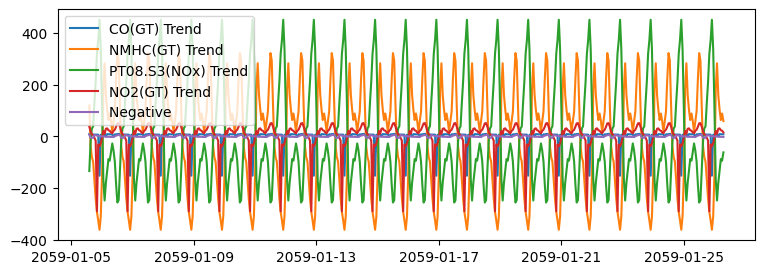

In [33]:
# Plotting 'Seasonal' Component

plt.figure(figsize=(9, 3))
plt.plot(result_add1.seasonal, label='CO(GT) Trend')
plt.plot(result_add2.seasonal, label='NMHC(GT) Trend')
plt.plot(result_add3.seasonal, label='PT08.S3(NOx) Trend')
plt.plot(result_add4.seasonal, label='NO2(GT) Trend')
plt.plot(result_addn.seasonal, label='Negative ')
plt.legend()

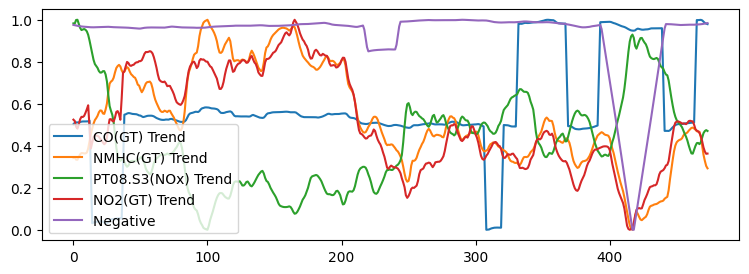

In [14]:
# Plot Normalized Components

plt.figure(figsize=(9, 3))
plt.plot(result_norm1, label='CO(GT) Trend')
plt.plot(result_norm2, label='NMHC(GT) Trend')
plt.plot(result_norm3, label='PT08.S3(NOx) Trend')
plt.plot(result_norm4, label='NO2(GT) Trend')
plt.plot(result_norm5, label='Negative ')
plt.legend()

In [15]:
# Compute Cosine Similarity

sim1 = np.dot(result_norm1.ravel(), result_norm2.ravel())/(norm(result_norm1.ravel())*norm(result_norm2.ravel()))
sim2 = np.dot(result_norm1.ravel(), result_norm3.ravel())/(norm(result_norm1.ravel())*norm(result_norm3.ravel()))
sim3 = np.dot(result_norm1.ravel(), result_norm4.ravel())/(norm(result_norm1.ravel())*norm(result_norm4.ravel()))
sim4 = np.dot(result_norm1.ravel(), result_norm5.ravel())/(norm(result_norm1.ravel())*norm(result_norm5.ravel()))

print(f"Cosine Similarity 1: {sim1}")
print(f"Cosine Similarity 2: {sim2}")
print(f"Cosine Similarity 3: {sim3}")
print(f"Cosine Similarity (N) 4: {sim4}")

Cosine Similarity 1: 0.7997714480244493
Cosine Similarity 2: 0.8321794476970561
Cosine Similarity 3: 0.8030943182085067
Cosine Similarity (N) 4: 0.8755075298590872


In [16]:
sim1 = np.dot(result_trend1.ravel(), result_trend2.ravel())/(norm(result_trend1.ravel())*norm(result_trend2.ravel()))
sim2 = np.dot(result_trend1.ravel(), result_trend3.ravel())/(norm(result_trend1.ravel())*norm(result_trend3.ravel()))
sim3 = np.dot(result_trend1.ravel(), result_trend4.ravel())/(norm(result_trend1.ravel())*norm(result_trend4.ravel()))
sim4 = np.dot(result_trend1.ravel(), result_trend5.ravel())/(norm(result_trend1.ravel())*norm(result_trend5.ravel()))

print(f"Cosine Similarity 1: {sim1}")
print(f"Cosine Similarity 2: {sim2}")
print(f"Cosine Similarity 3: {sim3}")
print(f"Cosine Similarity (N) 4: {sim4}")

Cosine Similarity 1: -0.7957367796777856
Cosine Similarity 2: -0.7705299899906065
Cosine Similarity 3: -0.7937068008644635
Cosine Similarity (N) 4: -0.3254186875557637


In [34]:
sim1 = np.dot(result_season1.ravel(), result_season2.ravel())/(norm(result_season1.ravel())*norm(result_season2.ravel()))
sim2 = np.dot(result_season1.ravel(), result_season3.ravel())/(norm(result_season1.ravel())*norm(result_season3.ravel()))
sim3 = np.dot(result_season1.ravel(), result_season4.ravel())/(norm(result_season1.ravel())*norm(result_season4.ravel()))
sim4 = np.dot(result_season1.ravel(), result_season5.ravel())/(norm(result_season1.ravel())*norm(result_season5.ravel()))

print(f"Cosine Similarity 1: {sim1}")
print(f"Cosine Similarity 2: {sim2}")
print(f"Cosine Similarity 3: {sim3}")
print(f"Cosine Similarity (N) 4: {sim4}")


Cosine Similarity 1: 0.38296188705150647
Cosine Similarity 2: -0.47031537209637236
Cosine Similarity 3: 0.12625733798923203
Cosine Similarity (N) 4: -0.03936286528820797


DTW distance: 448928.4125000002
DTW distance: 486852.16250000015
DTW distance: 44973.641666666685
DTW distance: 11759.281249999993


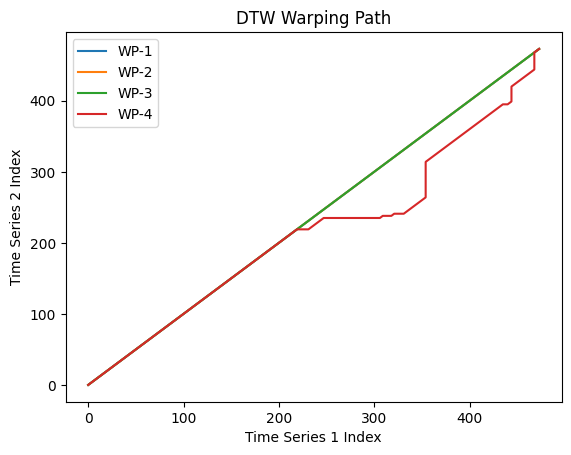

In [17]:
distance1, path1 = fastdtw(result_trend1.reshape(-1, 1), result_trend2.reshape(-1, 1), dist=euclidean)
distance2, path2 = fastdtw(result_trend1.reshape(-1, 1), result_trend3.reshape(-1, 1), dist=euclidean)
distance3, path3 = fastdtw(result_trend1.reshape(-1, 1), result_trend4.reshape(-1, 1), dist=euclidean)
distance4, path4 = fastdtw(result_trend1.reshape(-1, 1), result_trend5.reshape(-1, 1), dist=euclidean)

print(f"DTW distance: {distance1}")
print(f"DTW distance: {distance2}")
print(f"DTW distance: {distance3}")
print(f"DTW distance: {distance4}")

plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="WP-1")
plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="WP-2")
plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="WP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], '-', label="WP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()


DTW distance: 73634.96023574573
DTW distance: 66360.86605811413
DTW distance: 12866.817798793832
DTW distance: 5217.788180738296


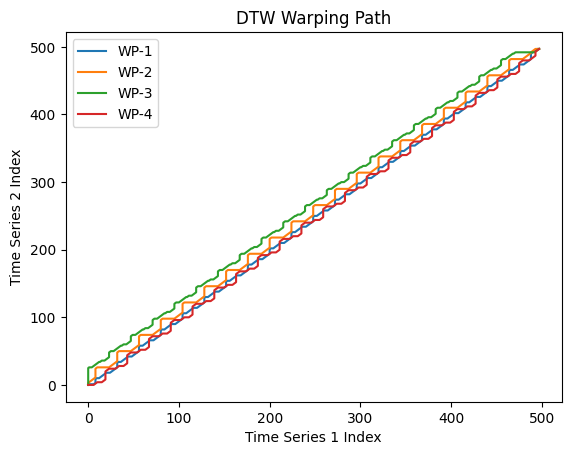

In [35]:
distance1, path1 = fastdtw(result_season1.reshape(-1, 1), result_season2.reshape(-1, 1), dist=euclidean)
distance2, path2 = fastdtw(result_season1.reshape(-1, 1), result_season3.reshape(-1, 1), dist=euclidean)
distance3, path3 = fastdtw(result_season1.reshape(-1, 1), result_season4.reshape(-1, 1), dist=euclidean)
distance4, path4 = fastdtw(result_season1.reshape(-1, 1), result_season5.reshape(-1, 1), dist=euclidean)

print(f"DTW distance: {distance1}")
print(f"DTW distance: {distance2}")
print(f"DTW distance: {distance3}")
print(f"DTW distance: {distance4}")

plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="WP-1")
plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="WP-2")
plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="WP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], '-', label="WP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()


In [18]:
arr_path = np.array(path1)
err = np.abs(arr_path[:, 0] - arr_path[:, 1])
avg_err = np.mean(err)
avg_err

np.float64(0.0)

DTW distance: 129.42975123443625
DTW distance: 62.756740962292895
DTW distance: 127.18430582398618
DTW distance: 170.84063400840932


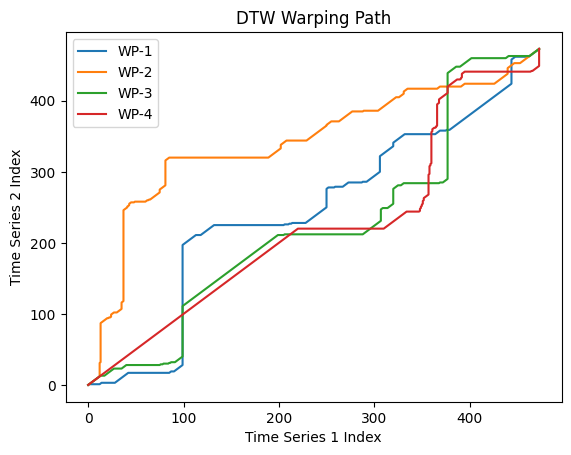

In [19]:
distance1, path1 = fastdtw(result_norm1, result_norm2, dist=euclidean)
distance2, path2 = fastdtw(result_norm1, result_norm3, dist=euclidean)
distance3, path3 = fastdtw(result_norm1, result_norm4, dist=euclidean)
distance4, path4 = fastdtw(result_norm1, result_norm5, dist=euclidean)

print(f"DTW distance: {distance1}")
print(f"DTW distance: {distance2}")
print(f"DTW distance: {distance3}")
print(f"DTW distance: {distance4}")

plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="WP-1")
plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="WP-2")
plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="WP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], '-', label="WP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()

In [20]:

# define two lists or array
A = np.array([2,1,2,3,2,9])
B = np.array([33,42,21,43,54,50])  # similar
# B = np.array([98, 65, 4, 12, 3, 6])  # different

scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

A_norm1 = scaler1.fit_transform(A.reshape(-1, 1))
A_norm2 = scaler2.fit_transform(A.reshape(-1, 1))
A_norm1 = A_norm1.ravel()
A_norm2 = A_norm2.ravel()

B_norm1 = scaler1.fit_transform(B.reshape(-1, 1))
B_norm2 = scaler2.fit_transform(B.reshape(-1, 1))
B_norm1 = B_norm1.ravel()
B_norm2 = B_norm2.ravel()
 
# compute cosine similarity
sim1 = np.dot(A,B)/(norm(A)*norm(B))
sim2 = np.dot(A_norm1,B_norm1)/(norm(A_norm1)*norm(B_norm1))
sim3 = np.dot(A_norm2,B_norm2)/(norm(A_norm2)*norm(B_norm2))

print("Cosine Similarity (Original):", sim1)
print("Cosine Similarity (MinMax):", sim2)
print("Cosine Similarity (ZScore):", sim3)

Cosine Similarity (Original): 0.8025931535467922
Cosine Similarity (MinMax): 0.6956449314632467
Cosine Similarity (ZScore): 0.38503648468374496


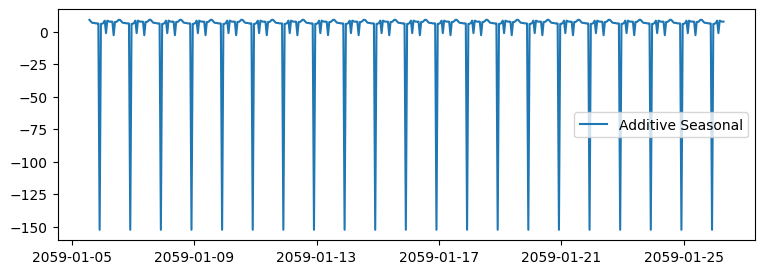

In [21]:
# Plotting 'Seasonal' Component

plt.figure(figsize=(9, 3))
plt.plot(result_add1.seasonal, label='Additive Seasonal')
plt.legend()

In [22]:
# Calculating the Simple Moving Average (SMA)
   
sma_window = 8  # 8-hour moving average
sma1 = ts_1.rolling(window=sma_window).mean()
sma2 = ts_2.rolling(window=sma_window).mean()
sma3 = ts_3.rolling(window=sma_window).mean()
sma4 = ts_4.rolling(window=sma_window).mean()
#sma1

In [23]:
# Calculating the Exponential Moving Average (EMA)

ema_window = 24  # 24-hour moving average
ema1 = ts_1.ewm(span=ema_window, adjust=False).mean()
ema2 = ts_2.ewm(span=ema_window, adjust=False).mean()
ema3 = ts_3.ewm(span=ema_window, adjust=False).mean()
ema4 = ts_4.ewm(span=ema_window, adjust=False).mean()
#ema1


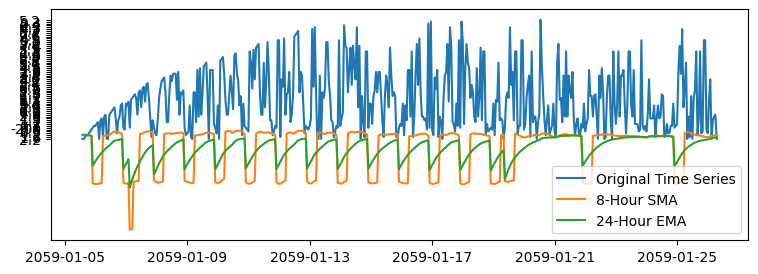

In [24]:
# Plotting the Moving Averages

plt.figure(figsize=(9, 3))
plt.plot(ts_1, label='Original Time Series')
plt.plot(sma1, label=f'{sma_window}-Hour SMA')
plt.plot(ema1, label=f'{ema_window}-Hour EMA')
plt.legend()